In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

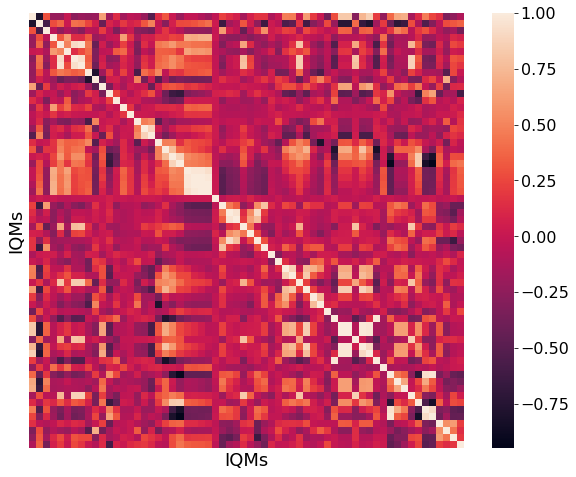

"SMALL_SIZE = 18\nMEDIUM_SIZE = 10\nBIGGER_SIZE = 12\n\nplt.rc('font', size=SMALL_SIZE)          # controls default text sizes\nplt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title\nplt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels\nplt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\nplt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\nplt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize\nplt.rc('figure', titlesize=BIGGER_SIZE)"

In [23]:
# LOAD ABIDE IQMs
data_path = os.path.join('/data','code','mriqc-learn','mriqc_learn','datasets','abide.tsv')

data = pd.read_csv(data_path, sep='\t')
iqms = data.drop(columns = ['subject_id', 'site', 'rater_1', 'rater_2', 'rater_3', 'size_x', 'size_y', 
                   'size_z', 'spacing_x', 'spacing_y', 'spacing_z'], inplace = False)
manual_ratings = data[['rater_1', 'rater_2', 'rater_3']]

fig = plt.figure(figsize=(10,8))
ax = sns.heatmap(iqms.corr(),xticklabels=False, yticklabels=False, square=True)
ax.set(xlabel='IQMs', ylabel='IQMs')
ax.set_xlabel("IQMs",fontsize=18)
ax.set_ylabel("IQMs",fontsize=18)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.show()

"""SMALL_SIZE = 18
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)"""

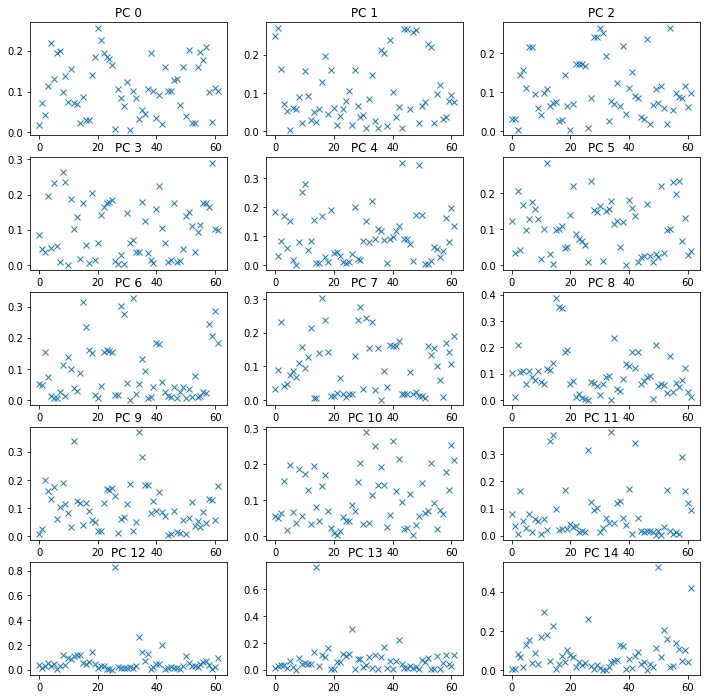

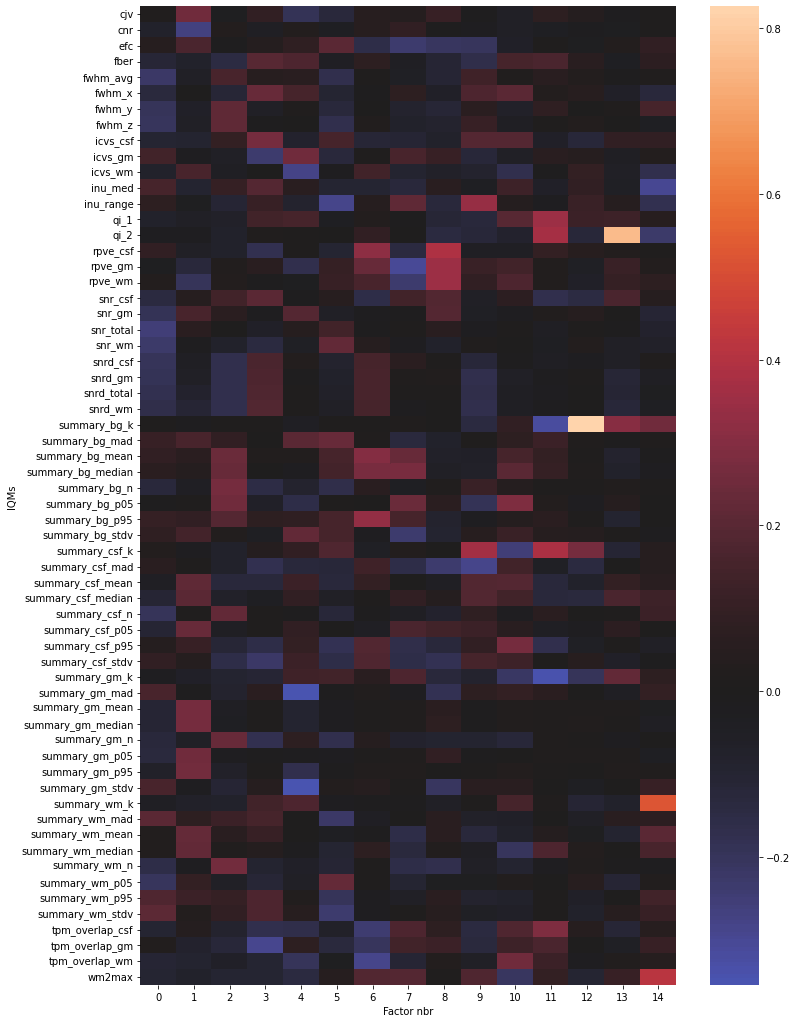

PC 7 is predominantly contributed to by ['efc' 'inu_range' 'rpve_gm' 'rpve_wm' 'summary_bg_mean'
 'summary_bg_median' 'summary_bg_p05' 'summary_bg_stdv'] with weights of respectively [-0.23064602  0.21322243 -0.30394424 -0.23818578  0.23758113  0.27555035
  0.24316921 -0.23243086]
PC 8 is predominantly contributed to by ['rpve_csf' 'rpve_gm' 'rpve_wm'] with weights of respectively [0.38939877 0.35444115 0.35060156]
PC 9 is predominantly contributed to by ['inu_range' 'summary_csf_k' 'summary_csf_mad'] with weights of respectively [ 0.33916531  0.36836827 -0.28261938]
PC 11 is predominantly contributed to by ['qi_1' 'qi_2' 'summary_bg_k' 'summary_csf_k' 'summary_gm_k'
 'tpm_overlap_csf'] with weights of respectively [ 0.34692841  0.3702738  -0.3171795   0.38000198 -0.34302224  0.29025643]
PC 12 is predominantly contributed to by ['summary_bg_k'] with weights of respectively [0.826498]
PC 13 is predominantly contributed to by ['qi_2'] with weights of respectively [0.76191527]
PC 14 is pr

In [4]:
# PCA
pca = PCA(n_components=None)
# Z-score so that each IQMs live in the same range of value
iqms_z = stats.zscore(iqms,axis=0)
pca.fit(iqms_z) #n_samples x n_features

"""#Plot cumulative variance explained
fig = plt.figure(figsize=(6,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100), '-x')
plt.ylabel('Cumulative variance explained [%]')
plt.xlabel('Nbr of components')
plt.xticks(list(range(0,pca.explained_variance_ratio_.size)))
plt.show()"""

#Plot PCA components' weights
basis = pca.components_[:15,:]
fig, axs = plt.subplots(5,3,sharex=False,sharey=False,figsize=(12,12))
for k in range(basis.shape[0]):
    axs[k//3,k%3].plot(abs(basis[k,:]),'x')
    axs[k//3,k%3].set_title('PC {}'.format(k))
    
fig = plt.figure(figsize=(12,18))
ax = sns.heatmap(basis.T, center=0)
ax.set_xlabel('Factor nbr')
ax.set_ylabel('IQMs')
ax.set_yticklabels(list(iqms.columns), rotation=0)
plt.show()

#Visually interesting components
pc = pca.components_[7,:]
ind = np.where(abs(pca.components_[7,:])>0.2)[0]
print('PC 7 is predominantly contributed to by {} with weights of respectively {}'
      .format(np.array(iqms.columns[ind]), pc[ind]))

pc = pca.components_[8,:]
ind = np.where(abs(pca.components_[8,:])>0.3)[0]
print('PC 8 is predominantly contributed to by {} with weights of respectively {}'
      .format(np.array(iqms.columns[ind]), pc[ind]))

pc = pca.components_[9,:]
ind = np.where(abs(pca.components_[9,:])>0.27)[0]
print('PC 9 is predominantly contributed to by {} with weights of respectively {}'
      .format(np.array(iqms.columns[ind]), pc[ind]))

pc = pca.components_[11,:]
ind = np.where(abs(pca.components_[11,:])>0.2)[0]
print('PC 11 is predominantly contributed to by {} with weights of respectively {}'
      .format(np.array(iqms.columns[ind]), pc[ind]))

pc = pca.components_[12,:]
ind = np.where(abs(pca.components_[12,:])>0.4)[0]
print('PC 12 is predominantly contributed to by {} with weights of respectively {}'
      .format(np.array(iqms.columns[ind]), pc[ind]))

pc = pca.components_[13,:]
ind = np.where(abs(pca.components_[13,:])>0.4)[0]
print('PC 13 is predominantly contributed to by {} with weights of respectively {}'
      .format(np.array(iqms.columns)[ind], pc[ind]))

pc = pca.components_[14,:]
ind = np.where(abs(pca.components_[14,:])>0.35)[0]
print('PC 14 is predominantly contributed to by {} with weights of respectively {}'
      .format(np.array(iqms.columns)[ind], pc[ind]))

In [5]:
# Helper function to decide on the nbr of factors

def parallel_analysis(data, k=20, method="minres", return_ev=False):
    import numpy as np
    import matplotlib.pyplot as plt
    from factor_analyzer import FactorAnalyzer

    # get shape of the data
    n, m = data.shape

    # initialize FactorAnalyzer
    fa = FactorAnalyzer(n_factors=m, rotation="varimax", method=method)

    # list to store eigenvalues
    eig = np.ones((k, m))

    # loop for k iterations
    for i in range(k):
        # print("Iteration", i+1)
        # generate random data
        rnd_data = np.random.normal(size=(n, m))
        # run factor analysis
        fa.fit(rnd_data)
        # extract eigenvalues
        ev, v = fa.get_eigenvalues()
        eig[i] = eig[i] * ev

    # average eigenvalues for random data
    avg_eig = np.mean(eig, axis=0)

    # run factor analysis on data
    fa.fit(data)
    ev, v = fa.get_eigenvalues()

    # determine suggested no. of factors
    suggestedFactors = sum((ev - avg_eig) > 0)
    if return_ev:
        return suggestedFactors, ev, avg_eig
    else:
        return suggestedFactors
    
    
def plot_pa_single(ev, avg_eig, save_plot = False):
    # plot eigenvalues of actual and random data
    sns.set_theme(style='white')
    fig, ax = plt.subplots(1, 1, figsize=(6,5))
    ax.plot(range(len(ev)), ev, marker="1", label="Real Data")
    ax.plot(range(len(ev)), avg_eig, marker="2", label="Synthetic Data")
    ax.set_xticks(range(0, len(ev), 10))
    ax.set_yticks(range(0, 13, 1))
    ax.set_xlabel('Factor Number')
    ax.set_ylabel('Eigenvalue')
    ax.set_title('Parallel Analysis')
    ax.legend()
    sns.despine()
    if save_plot == True:
        fig.savefig(outpath_efa+"parallel_analysis.svg")
    plt.show()
    return

/home/cprovins/miniconda3/lib/python3.8/site-packages/factor_analyzer/factor_analyzer.py:111: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
/home/cprovins/miniconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:249: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


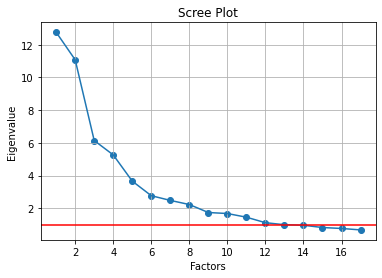

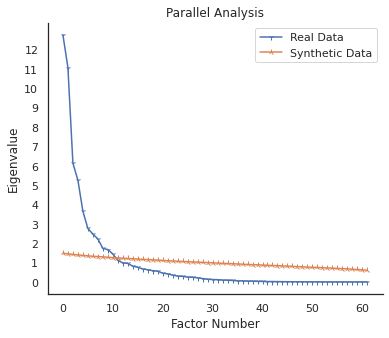

11


In [6]:
#Factor analysis (cf https://www.datacamp.com/community/tutorials/introduction-factor-analysis)

#Check that correlation matrix is not identity = sphericity check
chi_square_value,p_value=calculate_bartlett_sphericity(iqms)
if p_value > 0.5:
    raise ValueError('Their should be correlations in your data') 
    
#Check suitability of data for FA
kmo_all,kmo_model=calculate_kmo(iqms)
if kmo_model<0.6:
    raise ValueError('Data not suitable for FA')
    
fa = FactorAnalyzer()
fa.fit(iqms)

# Check Eigenvalues and keep a nbr of factor such that the eigenvalue is bigger than 1
ev, v = fa.get_eigenvalues()
plt.scatter(range(1,iqms.shape[1]+1-45),ev[:-45])
plt.plot(range(1,iqms.shape[1]+1-45),ev[:-45])
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r')
plt.grid()
plt.show()

#Null distribution of eigenvalues
suggestedFactors, ev22, avg_ev = parallel_analysis(iqms, k=20, method="ml", return_ev=True)
plot_pa_single(ev, avg_ev)

print(suggestedFactors)
n_factors = 9

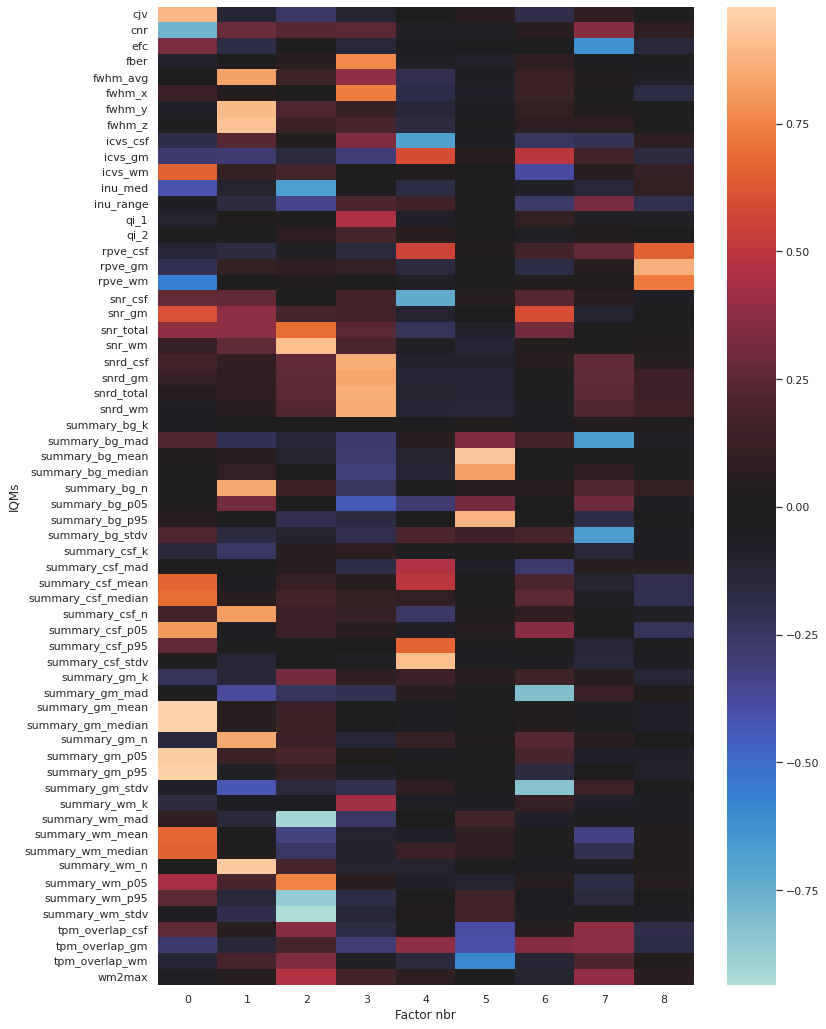

In [7]:
fa = FactorAnalyzer(rotation="varimax", n_factors=n_factors)
fa.fit(iqms)

fig = plt.figure(figsize=(12,18))
ax = sns.heatmap(fa.loadings_, center=0)
ax.set_xlabel('Factor nbr')
ax.set_ylabel('IQMs')
ax.set_yticklabels(list(iqms.columns), rotation=0)
plt.show()

Factor 0 is predominantly contributed to by ['cjv' 'cnr' 'icvs_wm' 'inu_med' 'rpve_wm' 'snr_gm' 'summary_csf_mean'
 'summary_csf_median' 'summary_csf_p05' 'summary_gm_mean'
 'summary_gm_median' 'summary_gm_p05' 'summary_gm_p95' 'summary_wm_mean'
 'summary_wm_median' 'summary_wm_p05'] with loadings of respectively [ 0.89137234 -0.7685909   0.65903783 -0.4088194  -0.55554555  0.61136363
  0.66512847  0.69185929  0.80998145  0.97823306  0.97872965  0.94301834
  0.95874242  0.67479508  0.66091329  0.44044793]
Factor 1 is predominantly contributed to by ['fwhm_avg' 'fwhm_y' 'fwhm_z' 'summary_bg_n' 'summary_csf_n'
 'summary_gm_n' 'summary_gm_stdv' 'summary_wm_n'] with loadings of respectively [ 0.83142789  0.89991263  0.92591619  0.85011775  0.81850981  0.8474604
 -0.42203544  0.93754403]
Factor 2 is predominantly contributed to by ['inu_med' 'snr_total' 'snr_wm' 'summary_wm_mad' 'summary_wm_p05'
 'summary_wm_p95' 'summary_wm_stdv' 'wm2max'] with loadings of respectively [-0.6684229   0.6933

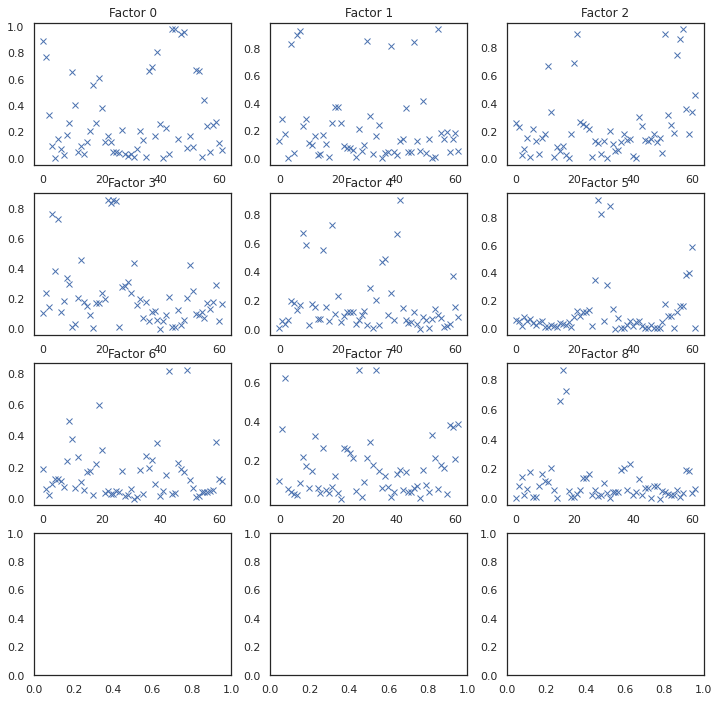

In [8]:
fig, axs = plt.subplots(4,3,sharex=False,sharey=False,figsize=(12,12))
for k in range(fa.loadings_.shape[1]):
    axs[k//3,k%3].plot(abs(fa.loadings_[:,k]),'x')
    axs[k//3,k%3].set_title('Factor {}'.format(k))

for i in range(fa.loadings_.shape[1]):
    factor = fa.loadings_[:,i]
    ind = np.where(abs(fa.loadings_[:,i])>0.4)[0]
    print('Factor {} is predominantly contributed to by {} with loadings of respectively {}'
          .format(i, np.array(iqms.columns)[ind], factor[ind]))

In [9]:
#Linear Discriminant analysis
lda = LinearDiscriminantAnalysis()
iqms_t = lda.fit_transform(iqms_z, manual_ratings.rater_3)

# define the pipeline
steps = [('lda', LinearDiscriminantAnalysis()), ('m', GaussianNB())]
model = Pipeline(steps=steps)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, iqms_z, manual_ratings.rater_3, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 0.898 (0.022)


In [10]:
#Backward feature elimination

#Check there are no missing values
if any(np.array(iqms.isnull().sum()) > 0):
       raise ValueError("There should not be missing values in your data")

#Scikit learn
k_features = 5
clf = LinearDiscriminantAnalysis()
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(clf, n_features_to_select=k_features, direction = 'backward')
sfs.fit(iqms_z, manual_ratings.rater_3)
print('The {} most important IQMs are {}'.format(k_features, np.array(iqms.columns[sfs.support_])))

The 5 most important IQMs are ['fwhm_y' 'fwhm_z' 'summary_bg_n' 'summary_wm_mad' 'summary_wm_mean']


In [11]:
#MLxtend
sfs1 = SFS(clf, 
           k_features=k_features, 
           forward=False, 
           verbose=0)
sfs1.fit(iqms_z, manual_ratings.rater_3)

kept_feat = list(sfs1.k_feature_names_)
print(kept_feat)

['fwhm_avg', 'fwhm_y', 'summary_bg_n', 'summary_csf_mean', 'summary_wm_mad']


In [12]:
feat_names = list(sfs1.k_feature_names_)

#print(sfs1.subsets_)
#feature eliminated in order
eliminated_feat = []
for i in reversed(range(k_features,iqms.shape[1]-1)):
    feat0 = sfs1.subsets_[i]['feature_names']
    feat1 = sfs1.subsets_[i+1]['feature_names']
    el_feat = list(set(feat1) - set(feat0))
    eliminated_feat.append(el_feat[0])

print(eliminated_feat)
print(kept_feat)

['cjv', 'summary_csf_median', 'summary_bg_stdv', 'qi_1', 'wm2max', 'summary_wm_n', 'summary_gm_median', 'summary_wm_stdv', 'rpve_csf', 'cnr', 'inu_range', 'summary_bg_mean', 'summary_bg_p95', 'summary_gm_mad', 'summary_bg_p05', 'summary_bg_k', 'tpm_overlap_csf', 'inu_med', 'summary_csf_k', 'summary_bg_mad', 'summary_csf_mad', 'snrd_wm', 'snr_wm', 'qi_2', 'icvs_wm', 'fwhm_z', 'summary_csf_p05', 'summary_wm_median', 'summary_gm_p05', 'rpve_gm', 'summary_gm_n', 'summary_wm_k', 'summary_bg_median', 'summary_gm_stdv', 'tpm_overlap_wm', 'tpm_overlap_gm', 'summary_csf_p95', 'summary_gm_k', 'summary_gm_mean', 'snrd_total', 'snrd_gm', 'summary_wm_p05', 'summary_wm_mean', 'snrd_csf', 'summary_gm_p95', 'summary_csf_n', 'rpve_wm', 'snr_gm', 'snr_total', 'efc', 'summary_wm_p95', 'icvs_csf', 'icvs_gm', 'summary_csf_stdv', 'snr_csf', 'fwhm_x']
['fwhm_avg', 'fwhm_y', 'summary_bg_n', 'summary_csf_mean', 'summary_wm_mad']


In [13]:
#using LDA
print('The 3 most important IQMs are {}'.format(np.array(iqms.columns[sfs.support_])))

The 3 most important IQMs are ['fwhm_y' 'fwhm_z' 'summary_bg_n' 'summary_wm_mad' 'summary_wm_mean']
